In [1]:
DEBUG = False

In [1]:
import os
import time
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
import albumentations
import matplotlib.pyplot as plt
from pylab import rcParams
import timm
import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold

In [3]:
class CFG:
    backbone = 'convnext_nano'
    device = 'cuda'
    image_size = 224
    n_slice_per_c = 15
    in_chans = 6
    out_dim = 1
    drop_rate = 0.
    drop_rate_last = 0.3
    drop_path_rate = 0.
    p_mixup = 0.5
    init_lr = 23e-5
    eta_min = 23e-6
    lw = [15, 1]
    n_epochs = 50
    batch_size = 4
    num_workers = 4
    use_amp = True

In [4]:
transforms_train = albumentations.Compose([
    albumentations.Resize(CFG.image_size, CFG.image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    # albumentations.OneOf([
    #     albumentations.OpticalDistortion(distort_limit=1.),
    #     albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    # ], p=0.5),

    # albumentations.Cutout(max_h_size=int(image_size * 0.5), max_w_size=int(image_size * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(CFG.image_size, CFG.image_size),
])

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(


len 4616
torch.Size([75, 6, 224, 224])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.])
torch.Size([75, 6, 224, 224])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1.])
torch.Size([75, 6, 224, 224])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.,

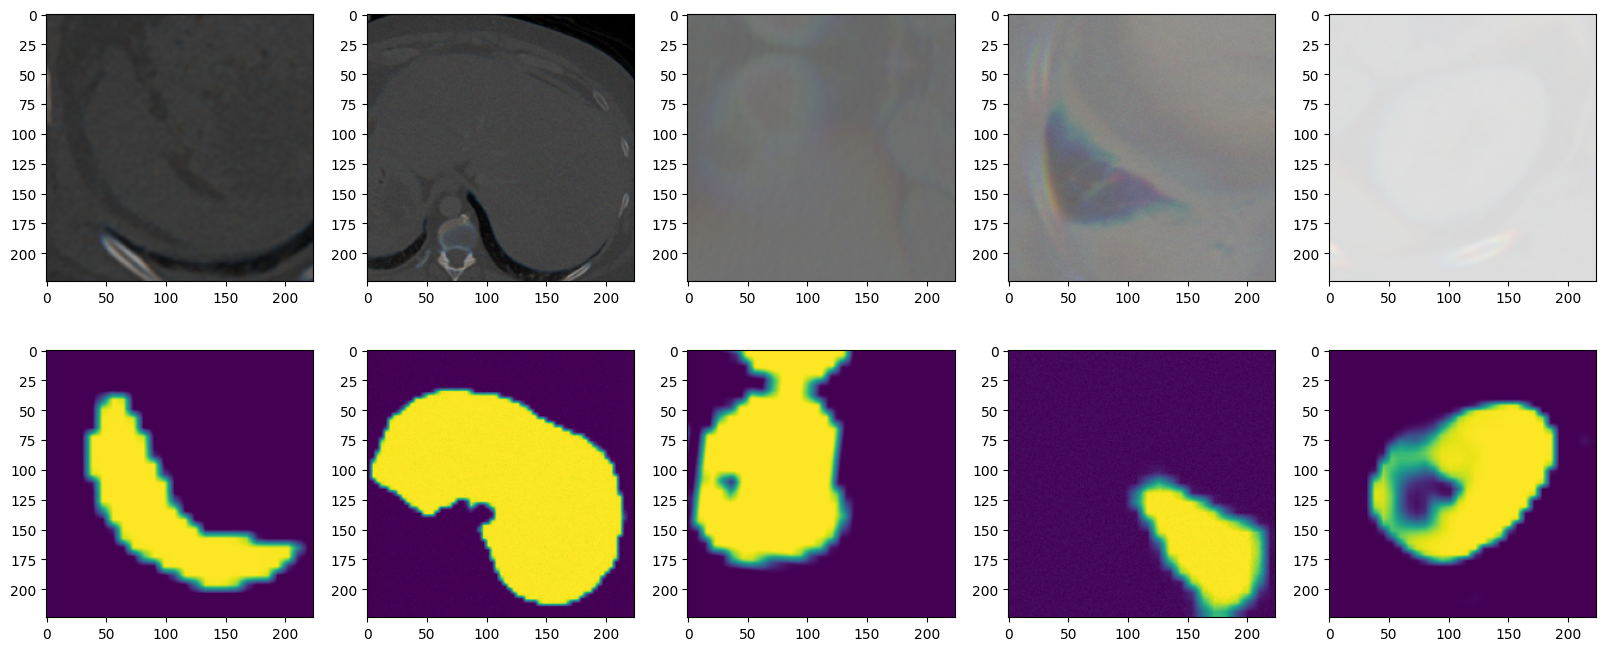

In [5]:
class ClsDataset(Dataset):
    def __init__(self, df, mode, transform):
        self.df = df
        self.mode = mode
        self.transform = transform
        self.map_cls = {0: 'liver', 1: 'spleen', 2: 'kidney', 3: 'kidney', 4: 'bowel'}

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        patient_id = row.patient_id
        study_id = row.study_id
        slice_num_list = row.slice_num_list
        before_image_size = row.before_image_size
        y0 = row.y0
        y1 = row.y1
        z0 = row.z0
        z1 = row.z1
        slice_list = []
        for s_num in slice_num_list:
            path = f"data/train_images/{patient_id}/{study_id}/{s_num}.dcm"
            img = load_dicom(path)
            if len(slice_list) == 0:
                imgh = img.shape[0]
                imgw = img.shape[1]
            elif img.shape != (imgh, imgw):
                img = cv2.resize(img, (imgh, imgw))
            slice_list.append(img)
        for _ in range(CFG.seg_len - len(slice_list)):
            slice_list.append(np.zeros((imgh, imgw)))
        image = np.stack(slice_list, axis=2)
        image = cv2.resize(img, (before_image_size, before_image_size))
        image = image[y0:y1, z0:z1, :]
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        image = np.transpose(image, (2, 0, 1))
        return torch.from_numpy(image), torch.tensor(row.label).float()
  
    
rcParams['figure.figsize'] = 20,8
df = pd.read_pickle(f"data/stage2/organ_df.pkl")
df = pd.read_csv('data/stage1/train_cls_type2.csv')
print('len', len(df))
df_show = df
dataset_show = ClsDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)


f, axarr = plt.subplots(2,5)
for p in range(5):
    idx = p + 5 * 0
    imgs, lbl = dataset_show[idx]
    print(imgs.size())
    print(lbl)
    axarr[0, p].imshow(imgs[3][:3].permute(1, 2, 0))
    axarr[1, p].imshow(imgs[3][-1])



In [6]:
class TimmModelType2(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModelType2, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=CFG.in_chans,
            num_classes=CFG.out_dim,
            features_only=False,
            drop_rate=CFG.drop_rate,
            drop_path_rate=CFG.drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(CFG.drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, CFG.out_dim),
        )
        self.lstm2 = nn.LSTM(hdim, 256, num_layers=2, dropout=CFG.drop_rate, bidirectional=True, batch_first=True)
        self.head2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(CFG.drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
        )



    def forward(self, x):  # (bs, nc*7, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * CFG.n_slice_per_c * 5, CFG.in_chans, CFG.image_size, CFG.image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, CFG.n_slice_per_c * 5, -1)
        feat1, _ = self.lstm(feat)
        feat1 = feat1.contiguous().view(bs * CFG.n_slice_per_c * 5, 512)
        feat2, _ = self.lstm2(feat)

        return self.head(feat1), self.head2(feat2[:, 0])

m = TimmModelType2(CFG.backbone)
u, v = m(torch.rand(2, CFG.n_slice_per_c *5, CFG.in_chans, CFG.image_size, CFG.image_size))
print(u.shape)
print(v.shape)

torch.Size([150, 1])
torch.Size([2, 1])


In [7]:
bce = nn.BCEWithLogitsLoss(reduction='none')


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = bce(logits.view(-1), targets.view(-1))
    losses[targets.view(-1) > 0] *= 2.
    norm = torch.ones(logits.view(-1).shape[0]).to(CFG.device)
    norm[targets.view(-1) > 0] *= 2
    return losses.sum() / norm.sum()

In [8]:
from sklearn.metrics import roc_auc_score


def calculate_auc(gts, outputs):
    gts = [tensor.detach().cpu().numpy() for tensor in gts]
    outputs = [tensor.sigmoid().detach().cpu().numpy() for tensor in outputs]
    gts = [np.mean(gt, axis=1) for gt in gts]
    outputs = [np.mean(output, axis=1) for output in outputs]
    total_auc_score = []
    for gt, output in zip(gts, outputs):
        try:
            auc_score = roc_auc_score(gt, output)
            total_auc_score.append(auc_score)
        except:
            # print('debug', gt)
            continue
    # print(total_auc_score)
    return sum(total_auc_score) / len(total_auc_score)


def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam


def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    train_loss1 = []
    train_loss2 = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        # if random.random() < CFG.p_mixup:
        #     do_mixup = True
        #     images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2 = criterion(logits2, targets.max(1).values)
            loss = (loss1 * CFG.lw[0] + loss2 * CFG.lw[1]) / sum(CFG.lw)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss1.append(loss1.item())
        train_loss2.append(loss2.item())
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    valid_loss1 = []
    valid_loss2 = []
    gts = []
    outputs = []
    outputs2 = []
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits, logits2 = model(images)
            loss1 = criterion(logits, targets)
            loss2= criterion(logits2, targets.max(1).values)
            loss = (loss1 + loss2) / 2.
            # gts.append(targets.cpu())
            # outputs.append(logits.cpu())
            # outputs2.append(logit2.cpu())
            valid_loss1.append(loss1.item())
            valid_loss2.append(loss2.item())
            valid_loss.append(loss.item())
            bar.set_description(f'smth:{np.mean(valid_loss1[-30:]):.4f} -- {np.mean(valid_loss2[-30:]):.4f}')
            

    return np.mean(valid_loss)

/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/data1/ocr_ie/anaconda3/envs/rsna/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unab

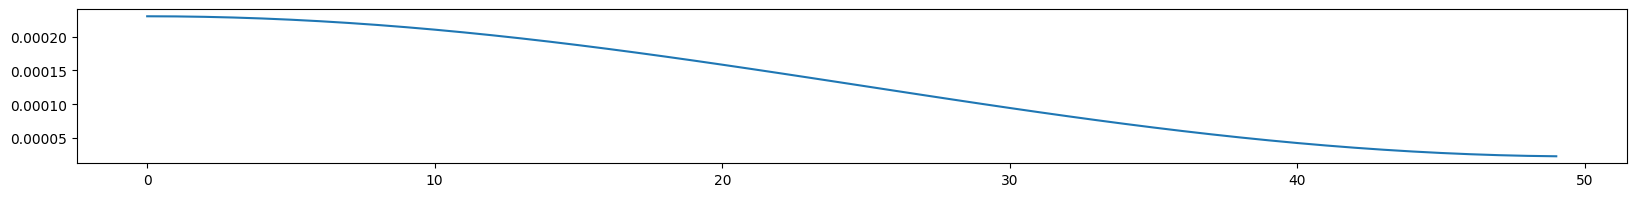

In [9]:
from pylab import rcParams
import matplotlib.pyplot as plt
import torch.optim as optim
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=CFG.init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

lrs = []
for epoch in range(1, CFG.n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

In [ ]:
log_dir = './logs'
model_dir = './weights'
DEBUG = False
def run(fold):
    df = pd.read_csv('data/stage1/train_cls_type2.csv')
    log_file = os.path.join(log_dir, f'type2_stage2_{CFG.backbone}_fold{fold}.txt')
    model_file = os.path.join(model_dir, f'type2_stage2_{CFG.backbone}_fold{fold}_best.pth')
    train_ = df[df['fold'] != fold].reset_index(drop=True)
    valid_ = df[df['fold'] == fold].reset_index(drop=True)
    dataset_train = ClsDataset(train_, 'train', transform=transforms_train)
    dataset_valid = ClsDataset(valid_, 'valid', transform=transforms_valid)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, drop_last=True)
    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers)

    model = TimmModelType2(CFG.backbone, pretrained=True)
    model = model.to(CFG.device)

    optimizer = optim.AdamW(model.parameters(), lr=CFG.init_lr)
    scaler = torch.cuda.amp.GradScaler() if CFG.use_amp else None
    metric_best = np.inf
    loss_min = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, CFG.n_epochs, eta_min=CFG.eta_min)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, CFG.n_epochs+1):
        scheduler_cosine.step(epoch-1)
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler)
        # train_loss = 0
        valid_loss = valid_func(model, loader_valid)
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(valid_loss):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()
run(0)

3692 924
Mon Oct  2 15:22:11 2023 Epoch: 1


smth:0.3453:  32%|███████████████████████████████████████▌                                                                                     | 292/923 [25:15<56:55,  5.41s/it]